In [86]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from scipy import optimize

In [141]:
dp = '/home/ebert/jupyter-notebooks/FNode-data'
exp_name = '2017_11_30_10_49_22_Iy-scan-op-heating'
exp_date = '_'.join(exp_name.split('_')[:3])
experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
cuts = [[22],[3]]

q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
q.set_thresholds(cuts)

name 'fort_exp' is not defined


In [142]:
q.experiments[0]['variable_list']
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']

In [143]:
retention = q.apply_thresholds()

In [144]:
tbl_str = "ivar:\t{0:.2f}\tretention:{1:.3f} +- {2:.3f}"
for i in range(len(retention['retention'].flatten())):
    print(tbl_str.format(
        retention['ivar'].flatten()[i],
        retention['retention'].flatten()[i],
        retention['error'].flatten()[i]
    ))

ivar:	0.00	retention:0.100 +- 0.036
ivar:	0.01	retention:0.060 +- 0.028
ivar:	0.01	retention:0.176 +- 0.045
ivar:	0.02	retention:0.160 +- 0.044
ivar:	0.02	retention:0.300 +- 0.055
ivar:	0.03	retention:0.440 +- 0.059
ivar:	0.03	retention:0.569 +- 0.058
ivar:	0.04	retention:0.608 +- 0.057
ivar:	0.04	retention:0.540 +- 0.059
ivar:	0.05	retention:0.520 +- 0.059
ivar:	0.05	retention:0.549 +- 0.059
ivar:	0.06	retention:0.420 +- 0.059
ivar:	0.06	retention:0.180 +- 0.046
ivar:	0.07	retention:0.200 +- 0.048
ivar:	0.07	retention:0.220 +- 0.049
ivar:	0.08	retention:0.180 +- 0.046


In [145]:
q.save_experiment_data()

In [146]:
def gaussian(x, a, x0, s, b):
    return b + a*np.exp(-0.5*((x-x0)/s)**2)

<IPython.core.display.Javascript object>


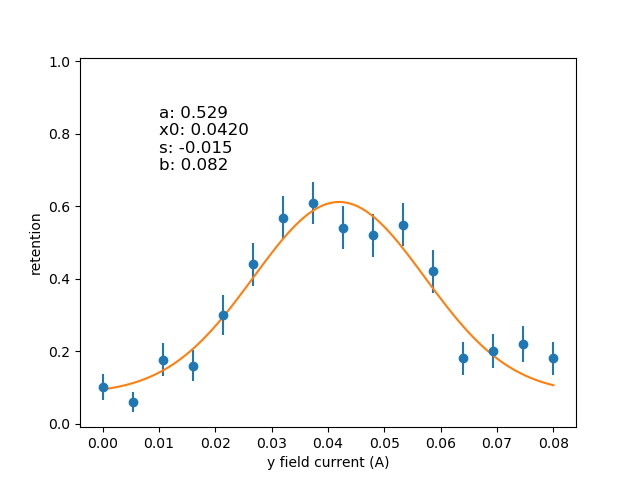

[ 0.52920291  0.04197553 -0.01521474  0.08243195]


In [150]:
fig, ax = plt.subplots()
for e in range(len(retention['ivar'])):
    ax.errorbar(retention['ivar'][e], retention['retention'][e],
                yerr=retention['error'][e],
                fmt = 'o'
    )
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel(xlab)

guess = [0.4, 0.04, 0.05, 0.1]
for e in range(len(retention['ivar'])):
    popt, pcov = optimize.curve_fit(
        gaussian,
        retention['ivar'][e],
        retention['retention'][e],
        p0=guess,
        sigma=retention['error'][e]
    )
    xs = np.linspace(min(retention['ivar'][e]),max(retention['ivar'][e]),100)
    ax.plot(xs, gaussian(xs, *popt))
    fit_data = "a: {:.3f}\nx0: {:.4f}\ns: {:.3f}\nb: {:.3f}"
    ax.text(0.01, 0.7, fit_data.format(*popt), fontsize=12)

ax.set_ylabel('retention')
print(popt)
fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'gaussian_retention_fit.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

In [40]:
1.984e-6+6.834682611

6.834684595

<IPython.core.display.Javascript object>


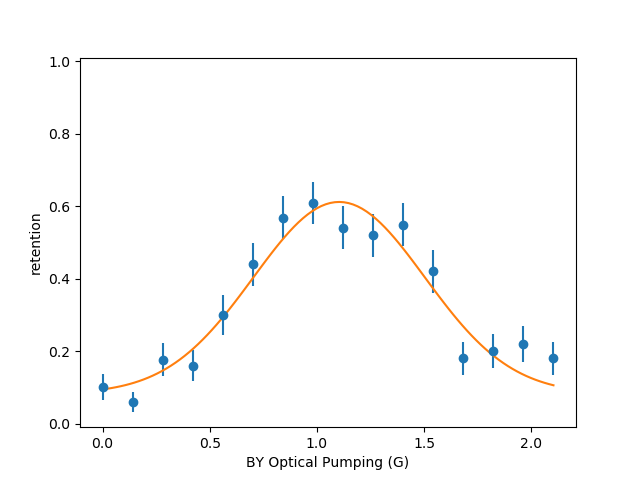

[ 0.52920291  0.04197553 -0.01521474  0.08243195]


In [148]:
b_cal = 26.3
fig, ax = plt.subplots()
for e in range(len(retention['ivar'])):
    ax.errorbar(retention['ivar'][e]*b_cal, retention['retention'][e],
                yerr=retention['error'][e],
                fmt = 'o'
    )
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel('BY Optical Pumping (G)')

for e in range(len(retention['ivar'])):
    xs = np.linspace(min(retention['ivar'][e]*b_cal),max(retention['ivar'][e]*b_cal),100)
    ax.plot(xs, gaussian(xs/b_cal, *popt))
    fit_data = "a: {:.3f}\nx0: {:.4f}\ns: {:.3f}\nb: {:.3f}"
    #ax.text(0.01, 0.7, fit_data.format(*popt), fontsize=12)

ax.set_ylabel('retention')
print(popt)
fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'gaussian_retention_fit.{}')
# for fmt in fmts:
#     fig.savefig(fn.format(fmt), dpi=200, format=fmt)